In [1]:
# A MUST-DO to disable annoying TensorFlow warning messages.
import os
import numpy as np

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
np.set_printoptions(suppress=True, precision=5)

In [2]:
from mtcnn.utils.tensorflow import set_gpu_memory_growth
set_gpu_memory_growth()

In [3]:
from mtcnn.stages import StagePNet
stage_pnet = StagePNet()

In [4]:
from mtcnn.utils.images import load_image, standarize_batch, normalize_images
image = load_image("example.jpg")

In [5]:
#images_normalized, images_oshapes, images_pad_params = standarize_batch([image], justification="center", normalize=True)

In [6]:
from mtcnn.utils.images import build_scale_pyramid, apply_scales, ensure_stack

In [7]:
np.asarray(image.shape) * 2

array([2780, 2600,    6])

In [8]:
scale_factor = 0.709
min_face_size = 20

images_oshapes = [image.shape]  # images_oshapes
images_normalized = image  # images_normalized 

# 1. Build the pyramid scale for every image based on the size and scale factor
scales_groups = [build_scale_pyramid(shape[1], shape[0], min_face_size=min_face_size, scale_factor=scale_factor) 
                 for shape in images_oshapes]

print(scales_groups)

# 2. Apply the scales to normalized images
scales_result, scales_index = apply_scales(images_normalized, scales_groups)
scales_size = scales_index.shape[0]
batch_size = images_normalized.shape[0]

[array([0.6    , 0.4254 , 0.30161, 0.21384, 0.15161, 0.10749, 0.07621,
       0.05403, 0.03831, 0.02716, 0.01926, 0.01365, 0.00968])]


In [35]:
scales_groups[0].round(5)

array([0.6    , 0.4254 , 0.30161, 0.21384, 0.15161, 0.10749, 0.07621,
       0.05403, 0.03831, 0.02716, 0.01926, 0.01365, 0.00968])

In [24]:
len(scales_groups[0])

13

In [36]:
[i.shape for i in scales_result]

[TensorShape([834, 780, 3]),
 TensorShape([591, 553, 3]),
 TensorShape([419, 392, 3]),
 TensorShape([297, 277, 3]),
 TensorShape([210, 197, 3]),
 TensorShape([149, 139, 3]),
 TensorShape([105, 99, 3]),
 TensorShape([75, 70, 3]),
 TensorShape([53, 49, 3]),
 TensorShape([37, 35, 3]),
 TensorShape([26, 25, 3]),
 TensorShape([18, 17, 3]),
 TensorShape([13, 12, 3])]

In [9]:
scales_result2 = [normalize_images(s) for s in scales_result]

In [11]:
images_normalized.shape

(1390, 1300, 3)

In [20]:
scales_result2[0].shape

TensorShape([834, 780, 3])

In [91]:
# 3. Get proposals bounding boxes and confidence from the model (PNet)
pnet_result = [stage_pnet.model(ensure_stack(s)) for s in scales_result2]

In [58]:
from mtcnn.utils.bboxes import generate_bounding_box, upscale_bboxes

In [92]:
threshold_pnet = 0.6

In [97]:
import numpy as np


def generate_bounding_box(bbox_reg, bbox_class, threshold_face, strides=2, cell_size=12):
    """
    Generates bounding boxes for detected objects (e.g., faces) based on the class and regression outputs of a model,
    supporting batch input.
    
    Args:
        bbox_reg (tf.Tensor): Bounding box regression predictions with shape (batch_size, height, width, 4).
                              This contains adjustments to apply to the initial bounding box positions for each image in the batch.
        bbox_class (tf.Tensor): Class predictions (e.g., face/non-face) of shape (batch_size, height, width, 2),
                                where the second channel corresponds to the probability of a face being present.
        threshold_face (float): A threshold between 0 and 1 that determines if a detection is considered a face or not.
                                Bounding boxes are only generated for detections with probabilities greater than this value.
        strides (int, optional): The step size (in pixels) used to slide the detection window over the image. Default is 2.
        cell_size (int, optional): The size of the sliding window (in pixels) used to detect faces. Default is 12.
    
    Returns:
        np.ndarray: An array of bounding boxes for the entire batch, where each box is represented as 
                    [batch_index, x1, y1, x2, y2, confidence].
                    The `batch_index` indicates which image in the batch the bounding box belongs to.
    """
    bbox_reg = bbox_reg.numpy()
    bbox_class = bbox_class.numpy()
    
    # Create a mask for detected faces based on the threshold for face probability
    confidence_score = bbox_class[:,:,:,1]
    
    # Find the indices where the detection mask is true (i.e., face detected)
    index_bboxes = np.stack(np.where(confidence_score > threshold_face)) # batch_size, y, x
    filtered_bbox_reg = np.transpose(bbox_reg[index_bboxes[0], index_bboxes[1], index_bboxes[2]], (1,0))
        
    # Extract the regression values
    reg_x1, reg_y1, reg_x2, reg_y2 = filtered_bbox_reg
    
    # Convert strides and cell size into arrays for easy broadcasting
    strides = np.asarray([[1], [strides], [strides]])
    cellsize = [np.asarray([[0], [1], [1]]), np.asarray([[0], [cell_size], [cell_size]])]

    # Calculate the top-left and bottom-right corners of the bounding boxes
    bbox_up_left = index_bboxes * strides + cellsize[0] 
    bbox_bottom_right = index_bboxes * strides + cellsize[1]
    
    # Calculate width and height for the bounding boxes
    reg_w = bbox_bottom_right[2] - bbox_up_left[2]  # width of bounding box
    reg_h = bbox_bottom_right[1] - bbox_up_left[1]  # height of bounding box
    
    # Apply the regression to adjust the bounding box coordinates
    x1 = bbox_up_left[2] + reg_x1 * reg_w  # Adjusted x1
    y1 = bbox_up_left[1] + reg_y1 * reg_h  # Adjusted y1
    x2 = bbox_bottom_right[2] + reg_x2 * reg_w  # Adjusted x2
    y2 = bbox_bottom_right[1] + reg_y2 * reg_h  # Adjusted y2

    # Concatenate the bounding box coordinates and detection information, keeping batch index
    bboxes_result = np.stack([
        index_bboxes[0], x1, y1, x2, y2, confidence_score[index_bboxes[0], index_bboxes[1], index_bboxes[2]]
    ], axis=0).T
    
    # Sort bounding boxes by score in descending order
    #bboxes_result = sort_by_scores(bboxes_result, scores=bboxes_result[:, -1], ascending=False)

    return bboxes_result

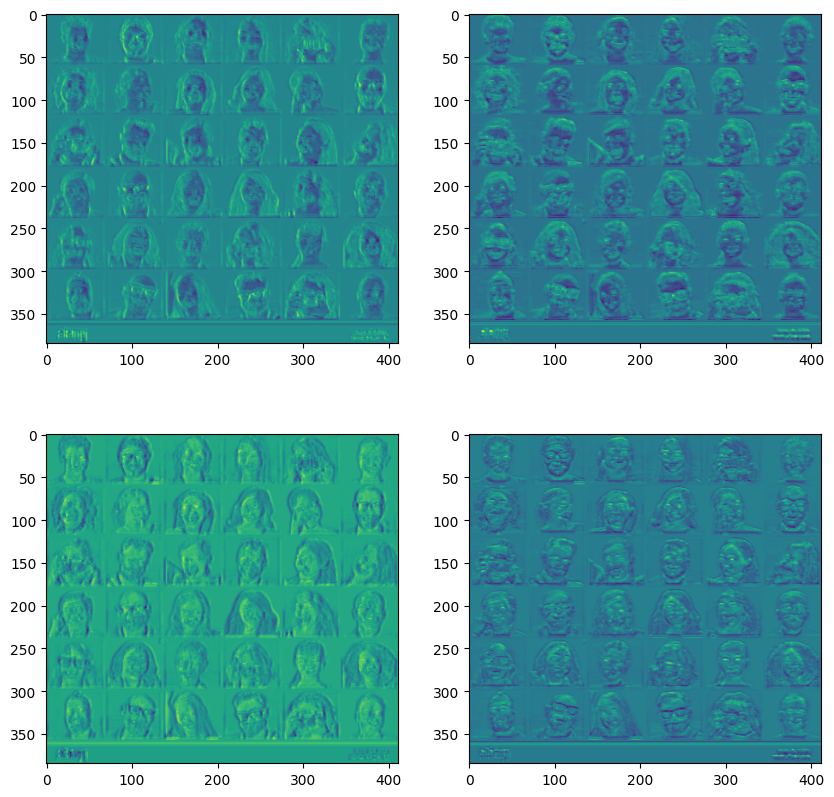

In [99]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10,10)
plt.subplot(221)
plt.imshow(pnet_result[0][0][0,:,:,0])
plt.subplot(222)
plt.imshow(pnet_result[0][0][0,:,:,1])
plt.subplot(223)
plt.imshow(pnet_result[0][0][0,:,:,2])
plt.subplot(224)
plt.imshow(pnet_result[0][0][0,:,:,3])

In [98]:
pnet_result[0]

[<tf.Tensor: shape=(1, 385, 412, 4), dtype=float32, numpy=
 array([[[[-0.03374, -0.17321,  0.05641,  0.16093],
          [-0.03374, -0.17321,  0.05641,  0.16093],
          [-0.03374, -0.17321,  0.05641,  0.16093],
          ...,
          [-0.0338 , -0.173  ,  0.0562 ,  0.16096],
          [-0.03365, -0.1732 ,  0.05623,  0.16073],
          [-0.03361, -0.17315,  0.05645,  0.16097]],
 
         [[-0.03374, -0.17321,  0.05641,  0.16093],
          [-0.03374, -0.17321,  0.05641,  0.16093],
          [-0.03374, -0.17321,  0.05641,  0.16093],
          ...,
          [-0.0338 , -0.173  ,  0.0562 ,  0.16096],
          [-0.03365, -0.1732 ,  0.05623,  0.16073],
          [-0.03361, -0.17315,  0.05645,  0.16097]],
 
         [[-0.03374, -0.17321,  0.05641,  0.16093],
          [-0.03374, -0.17321,  0.05641,  0.16093],
          [-0.03374, -0.17321,  0.05641,  0.16093],
          ...,
          [-0.0338 , -0.173  ,  0.0562 ,  0.16096],
          [-0.03365, -0.1732 ,  0.05623,  0.16073],
      

In [93]:
bboxes_proposals = [generate_bounding_box(result[0], result[1], threshold_pnet) for result in pnet_result]
bboxes_batch_upscaled = [upscale_bboxes(bbox, np.asarray([scale] * batch_size)) for bbox, scale in zip(bboxes_proposals, scales_index)]

In [95]:
bboxes_batch_upscaled[0]

array([[   0.     ,   55.26693,  507.46537,   74.39379,  530.54846,
           0.99973],
       [   0.     , 1243.01043,  682.85398, 1261.93146,  706.606  ,
           0.99825],
       [   0.     ,   56.56322,  509.75583,   73.14493,  528.91551,
           0.99757],
       ...,
       [   0.     , 1096.01366, 1184.11831, 1113.01185, 1203.83316,
           0.60098],
       [   0.     , 1051.92223,  560.08076, 1071.41452,  583.70627,
           0.60029],
       [   0.     , 1352.7252 ,  929.77512, 1371.43073,  952.43169,
           0.60003]])

In [94]:
for b in bboxes_batch_upscaled:
    print(b.shape)

(844, 6)
(662, 6)
(541, 6)
(558, 6)
(669, 6)
(486, 6)
(288, 6)
(133, 6)
(18, 6)
(5, 6)
(0, 6)
(0, 6)
(0, 6)
